In [61]:
pip install pandas scipy numpy matplotlib plotly folium scikit-learn jupyterlab ipynbname seaborn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /Users/fritz/venvs/jupyter-env/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [62]:
DATA = "DATA AIRBNB2.csv"
# ==============================
# Global constants
# ==============================

# Cluster labels (stable meaning)
CLUSTER_LABELS = {
    0: "Cheap",
    1: "Mid",
    2: "High"
}

# Cluster colors (must match the numeric keys above)
CLUSTER_COLORS = ['green', 'orange', 'red']  # 0=Cheap, 1=Mid, 2=High
N_CLUSTERS = 3
RANDOM_STATE = 42


In [63]:
import pandas as pd
from pathlib import Path

# Get current working directory safely
current_dir = Path.cwd()
print("Current directory:", current_dir)

csv_path = current_dir / DATA

print("Looking for CSV at:", csv_path)
if not csv_path.exists():
    raise FileNotFoundError(f"File not found: {csv_path}")

df = pd.read_csv(csv_path, delimiter=";")
print(df.head())


Current directory: /Users/fritz/Library/CloudStorage/OneDrive-GUSCanada/PROGRESS/2025-1st term - Winter Term/DAMO-520-5 - Marketing Analytics/kmeans-final-presentation/airbnb
Looking for CSV at: /Users/fritz/Library/CloudStorage/OneDrive-GUSCanada/PROGRESS/2025-1st term - Winter Term/DAMO-520-5 - Marketing Analytics/kmeans-final-presentation/airbnb/DATA AIRBNB2.csv
       id                                      name  host_id  \
0  261065          Westboro Village Executive Suite  1369632   
1  290033             Rural charm close to the city   415201   
2  490182         Basement Studio - Old Ottawa East  2401179   
3  674799  Up to 3-bdrm with privacy - quiet & safe  2058676   
4  682632       Adorable 2 bdrm, Central Ottawa PD1  3201295   

          host_name neighbourhood_group            neighbourhood  latitude  \
0             Glenn                 NaN             Kitchissippi  45.39084   
1            Daniel                 NaN         Rideau-Goulbourn  45.16820   
2            

# Data cleaning

In [64]:
import pandas as pd
import numpy as np

# Load the data
#df = pd.read_csv('DATA AIRBNB.csv', delimiter=';')
print(f"Initial number of rows: {len(df)}")

# Handle missing values in 'price'
missing_price_before = df['price'].isna().sum()
df['price'].fillna(df['price'].median(), inplace=True)
missing_price_after = df['price'].isna().sum()
print(f"Missing values in 'price' filled with median: {missing_price_before - missing_price_after}")

# Handle missing values in 'license'
missing_license_before = df['license'].isna().sum()
df['license'].fillna('Unknown', inplace=True)
missing_license_after = df['license'].isna().sum()
print(f"Missing values in 'license' filled with 'Unknown': {missing_license_before - missing_license_after}")

# Convert 'last_review' to datetime and handle missing values
missing_last_review_before = df['last_review'].isna().sum()
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
missing_last_review_after = df['last_review'].isna().sum()
print(f"Rows with invalid 'last_review' converted to NaT: {missing_last_review_after - missing_last_review_before}")

# Find all duplicate rows across all columns
duplicates = df[df.duplicated(keep=False)]
print(f"Number of duplicate rows across all columns: {len(duplicates)}")
print("Duplicate rows:")
print(duplicates)

# Remove duplicates (keeping the first occurrence)
rows_before_duplicates = len(df)
df.drop_duplicates(inplace=True)
rows_after_duplicates = len(df)
print(f"Rows removed due to duplicates: {rows_before_duplicates - rows_after_duplicates}")

# Handle outliers in 'price'
rows_before_outliers = len(df)
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['price'] >= Q1 - 1.5 * IQR) & (df['price'] <= Q3 + 1.5 * IQR)]
rows_after_outliers = len(df)
print(f"Rows removed due to 'price' outliers: {rows_before_outliers - rows_after_outliers}")

# Standardize 'license' column
df['license'] = df['license'].apply(lambda x: 'Exempt' if x == 'Exempt' else ('Licensed' if pd.notna(x) else 'Unknown'))
print(f"Standardized 'license' column: {df['license'].value_counts().to_dict()}")

# Convert 'price' to numeric
invalid_price_before = df['price'].isna().sum()
df['price'] = pd.to_numeric(df['price'], errors='coerce')
invalid_price_after = df['price'].isna().sum()
print(f"Rows with invalid 'price' values converted to NaN: {invalid_price_after - invalid_price_before}")

# Feature engineering: 'days_since_last_review'
df['days_since_last_review'] = (pd.to_datetime('today') - df['last_review']).dt.days
missing_days_since_last_review = df['days_since_last_review'].isna().sum()
print(f"Rows with missing 'days_since_last_review': {missing_days_since_last_review}")

# Convert 'latitude' and 'longitude' to numeric
invalid_latitude_before = df['latitude'].isna().sum()
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
invalid_latitude_after = df['latitude'].isna().sum()
print(f"Rows with invalid 'latitude' values converted to NaN: {invalid_latitude_after - invalid_latitude_before}")

invalid_longitude_before = df['longitude'].isna().sum()
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')
invalid_longitude_after = df['longitude'].isna().sum()
print(f"Rows with invalid 'longitude' values converted to NaN: {invalid_longitude_after - invalid_longitude_before}")

# Check for inconsistencies in 'latitude' and 'longitude'
rows_before_geo_filter = len(df)
df = df[(df['latitude'] >= 45.0) & (df['latitude'] <= 46.0)]
df = df[(df['longitude'] >= -76.0) & (df['longitude'] <= -75.0)]
rows_after_geo_filter = len(df)
print(f"Rows removed due to invalid geographic coordinates: {rows_before_geo_filter - rows_after_geo_filter}")

# Drop rows with NaN in 'latitude' or 'longitude'
rows_before_drop_na = len(df)
df = df.dropna(subset=['latitude', 'longitude'])
rows_after_drop_na = len(df)
print(f"Rows removed due to NaN in 'latitude' or 'longitude': {rows_before_drop_na - rows_after_drop_na}")

# Save cleaned data
df.to_csv('cleaned_DATA_AIRBNB2.csv', index=False)
print(f"Final number of rows in cleaned dataset: {len(df)}")

Initial number of rows: 2857
Missing values in 'price' filled with median: 323
Missing values in 'license' filled with 'Unknown': 994
Rows with invalid 'last_review' converted to NaT: 16
Number of duplicate rows across all columns: 0
Duplicate rows:
Empty DataFrame
Columns: [id, name, host_id, host_name, neighbourhood_group, neighbourhood, latitude, longitude, room_type, price, minimum_nights, number_of_reviews, last_review, reviews_per_month, calculated_host_listings_count, availability_365, number_of_reviews_ltm, license]
Index: []
Rows removed due to duplicates: 0
Rows removed due to 'price' outliers: 181
Standardized 'license' column: {'Licensed': 2453, 'Exempt': 223}
Rows with invalid 'price' values converted to NaN: 0
Rows with missing 'days_since_last_review': 503
Rows with invalid 'latitude' values converted to NaN: 0
Rows with invalid 'longitude' values converted to NaN: 18
Rows removed due to invalid geographic coordinates: 68
Rows removed due to NaN in 'latitude' or 'longitu

/var/folders/g4/9k6f6c210td2wglzkky_kdhw0000gn/T/ipykernel_70663/2920006063.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['price'].fillna(df['price'].median(), inplace=True)
/var/folders/g4/9k6f6c210td2wglzkky_kdhw0000gn/T/ipykernel_70663/2920006063.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting val

# K means clustering 3d using rent, latitude, longitude

### determining number of clusters

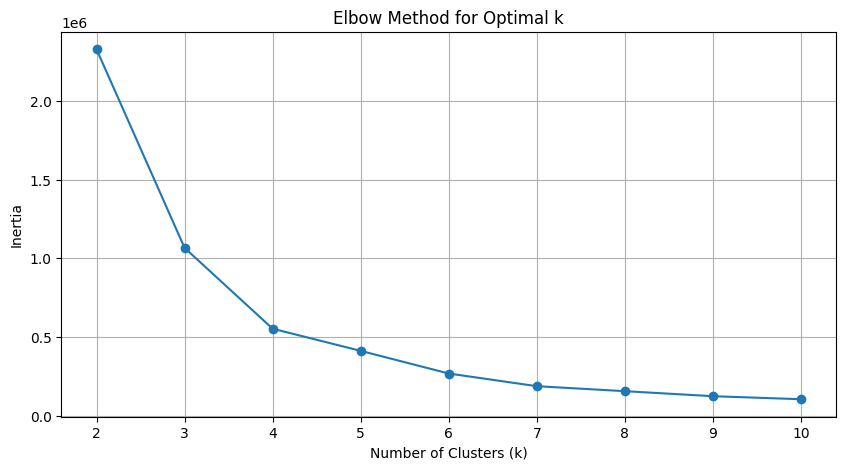

The optimal number of clusters based on the Elbow Method is: 3


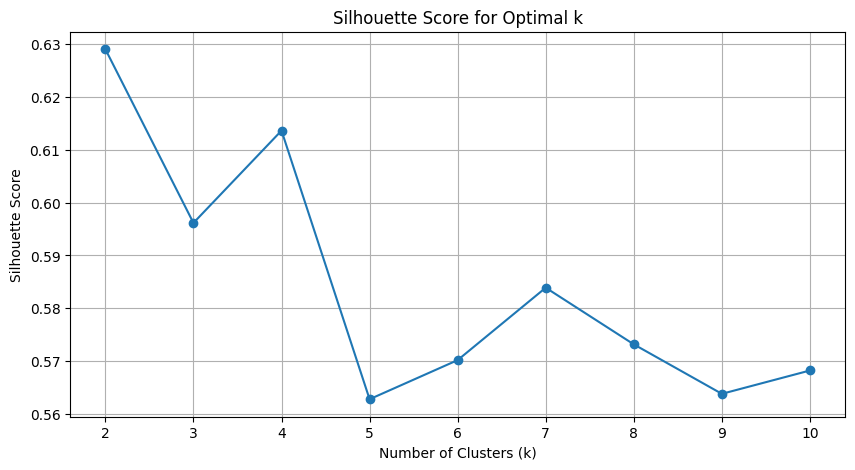

The optimal number of clusters based on Silhouette Score is: 2


In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load your Airbnb data
# Assuming the data has columns 'latitude', 'longitude', and 'rent_price'
data = pd.read_csv('cleaned_DATA_AIRBNB2.csv')
X = data[['latitude', 'longitude', 'price']].values  # Ensure 'price' is the correct column name

# Elbow Method
inertia = []
k_values = range(2, 11)  # Testing k from 2 to 10

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Method
plt.figure(figsize=(10, 5))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid()
plt.show()

# Finding the elbow point (simple heuristic)
# Calculate the differences between consecutive inertia values
inertia_diff = np.diff(inertia)
inertia_diff2 = np.diff(inertia_diff)

# Find the index of the maximum second derivative
elbow_index = np.argmax(inertia_diff2) + 1  # +1 because of the diff operation
optimal_k_elbow = k_values[elbow_index]

print(f'The optimal number of clusters based on the Elbow Method is: {optimal_k_elbow}')

# Silhouette Score
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plotting the Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid()
plt.show()

# Output the optimal number of clusters based on Silhouette Score
optimal_k_silhouette = k_values[np.argmax(silhouette_scores)]
print(f'The optimal number of clusters based on Silhouette Score is: {optimal_k_silhouette}')

### 3d visualization 2


Saved: cleaned_DATA_AIRBNB2_with_price_clusters.csv


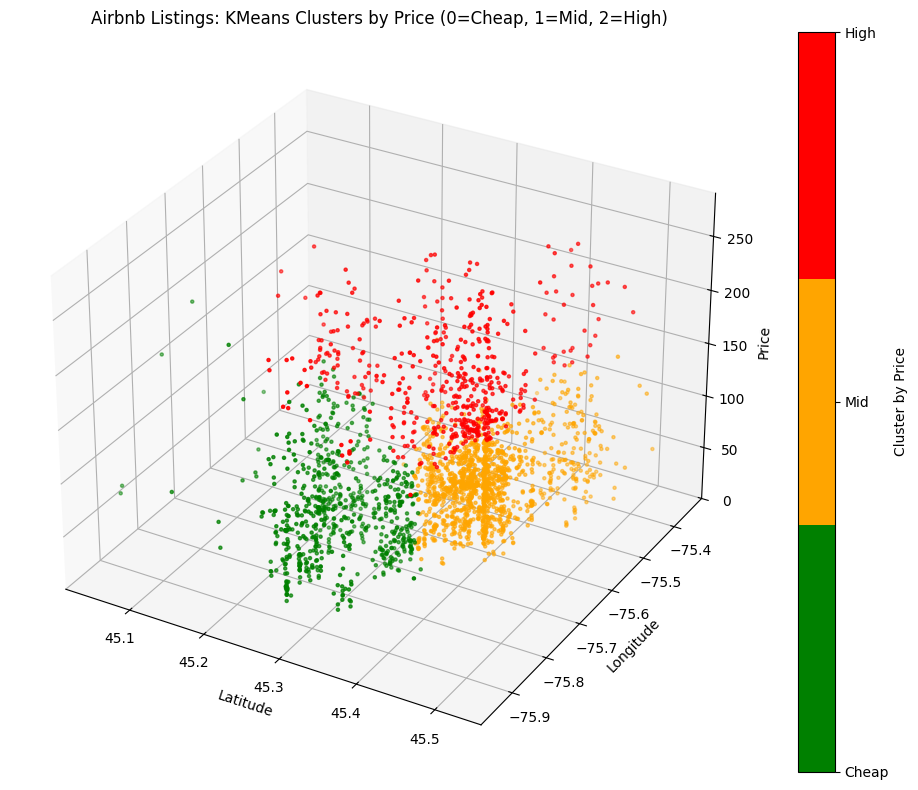

   latitude  longitude  price  cluster
0  45.39084  -75.75621  159.0        2
1  45.16820  -75.71208  228.0        2
2  45.40550  -75.67612   78.0        1
3  45.26910  -75.72197   63.0        0
4  45.40455  -75.73130  105.0        1


In [66]:
#!/usr/bin/env python3
"""
KMeans clustering of Airbnb data with stable, price-ordered cluster labels.

- Reads:  cleaned_DATA_AIRBNB2.csv
- Uses features: latitude, longitude, price
- Clusters: 3 (random_state=42 for reproducibility)
- Relabels clusters so that:
    0 = Cheap, 1 = Mid, 2 = High   (by average price)
- Saves: cleaned_DATA_AIRBNB2_with_price_clusters.csv
- Plots: 3D scatter with consistent colors and labels
"""

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401  (required for 3D projection import side-effect)
import matplotlib.colors as mcolors

# -----------------------
# Config
# -----------------------
INPUT_CSV  = "cleaned_DATA_AIRBNB2.csv"
OUTPUT_CSV = "cleaned_DATA_AIRBNB2_with_price_clusters.csv"
N_CLUSTERS = 3
RANDOM_STATE = 42




def main():
    # ---- Load data
    data = pd.read_csv(INPUT_CSV)
    required_cols = ['latitude', 'longitude', 'price']
    missing = [c for c in required_cols if c not in data.columns]
    if missing:
        raise ValueError(f"Missing required columns in {INPUT_CSV}: {missing}")

    # Drop rows with NA or non-finite values in required columns
    data = data.replace([np.inf, -np.inf], np.nan).dropna(subset=required_cols).copy()

    # Ensure price is numeric
    data['price'] = pd.to_numeric(data['price'], errors='coerce')
    data = data.dropna(subset=['price'])

    # ---- Features
    X = data[['latitude', 'longitude', 'price']].to_numpy()

    # ---- Scale
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # ---- KMeans (reproducible)
    kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE, n_init='auto')
    labels = kmeans.fit_predict(X_scaled)

    data['cluster_raw'] = labels  # keep raw labels just in case

    # ---- Relabel by average price: 0=cheapest ... 2=priciest
    avg_price_by_cluster = data.groupby('cluster_raw')['price'].mean().sort_values()
    # avg_price_by_cluster.index is the old label order from cheapest to priciest
    label_mapping = {old_label: new_label for new_label, old_label in enumerate(avg_price_by_cluster.index)}
    data['cluster'] = data['cluster_raw'].map(label_mapping)

    # ---- Save CSV
    data.to_csv(OUTPUT_CSV, index=False)
    print(f"Saved: {OUTPUT_CSV}")

    # ---- 3D Plot (consistent colors & labels)
    # Build a colormap that matches label order 0,1,2
    if len(CLUSTER_COLORS) != N_CLUSTERS:
        raise ValueError("COLORS list length must equal N_CLUSTERS.")
    cmap = mcolors.ListedColormap(CLUSTER_COLORS)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(
        data['latitude'], data['longitude'], data['price'],
        c=data['cluster'], cmap=cmap, s=5
    )

    # Colorbar with friendly labels
    cbar = plt.colorbar(scatter, ticks=list(range(N_CLUSTERS)))
    cbar.set_label('Cluster by Price')
    cbar.set_ticklabels([CLUSTER_LABELS[i] for i in range(N_CLUSTERS)])

    # Axis labels & limits
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_zlabel('Price')

    ax.set_xlim(left=data['latitude'].min())
    ax.set_ylim(bottom=data['longitude'].min())
    ax.set_zlim(bottom=0)

    plt.title('Airbnb Listings: KMeans Clusters by Price (0=Cheap, 1=Mid, 2=High)')
    plt.tight_layout()
    plt.show()

    # Quick peek
    print(data[['latitude', 'longitude', 'price', 'cluster']].head())


if __name__ == "__main__":
    main()


# Interpretation of data with clusters

### 1. Price Distrubution per Cluster


In [67]:
import pandas as pd

# Load the datas
data = pd.read_csv('cleaned_DATA_AIRBNB2_with_price_clusters.csv')

# Group the data by cluster
clustered_data = data.groupby('cluster')

# Analyze price distribution per cluster
price_analysis = clustered_data['price'].agg(['mean', 'min', 'max'])
print("Price Distribution per Cluster:")
print(price_analysis)

Price Distribution per Cluster:
               mean    min    max
cluster                          
0         82.013643   25.0  225.0
1         86.746334   18.0  171.0
2        188.673190  129.0  271.0


##### Interpretation
- Cluster 2: High-price accomodations. Price ranges between $127 to $271 with Average/Mean price of $187.9. The price range is very narrow, this suggest that accomondations that below here likely refers to premium or luxury accommodations or entireh homes/apartments in prime locations.
- Cluster 1: Mid-price accomodations. Price ranges between $18 to $171 with Average price of $86. The price range is considered wide, indicating variability pricing. These are moderately priced accommodations. Mix of budget-friently and moderately priced accomodations with some very affordable options.
- Cluster 0: Low-price accomodation. Price ranges $25 to $225 with Average/Mean price of $83.34. Even wider price range, the range from $25 to $225. These are budget-friendly accommodations. This cluster includes both budget friendly options and some higher-priced accomodations. Includes both budget-friently and higher priced listings.

In [68]:
# Analyze room types per cluster
room_type_analysis = data.groupby('cluster')['room_type'].value_counts()
print("Room Type Distribution per Cluster:")
print(room_type_analysis)

Room Type Distribution per Cluster:
cluster  room_type      
0        Private room       466
         Entire home/apt    266
         Shared room          1
1        Entire home/apt    765
         Private room       598
         Shared room          1
2        Entire home/apt    479
         Private room        30
         Hotel room           2
Name: count, dtype: int64


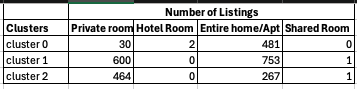

#### Interpretation
##### Cluster 2
- Mostly refers to Entire Homes/apt, more expensive compared to others.
- Variability is present because of private rooms and hotel rooms are present, but still primarily is high-priced accomodations.
##### Cluster 1
- Balanced mix of Entire Home/apt and private room listings.
- Wide range of options inclusive, private rooms for affordability and entire home/apts for moderately priced options.
##### Cluster 0
- Dominated by Private rooms that are more for budget conscious travellers
- Variability is present because of Entire home/apts but cluster are primarily budget-friendly accomodations. 
- Considered lower price as private rooms are generally cheaper.

### 2. Geographical Distribution per cluster

In [69]:
# Analyze geographical distribution per cluster
geo_analysis = clustered_data[['latitude', 'longitude']].mean()
print("\nGeographical Distribution per Cluster:")
print(geo_analysis)


Geographical Distribution per Cluster:
          latitude  longitude
cluster                      
0        45.290913 -75.804777
1        45.411739 -75.646685
2        45.378307 -75.689922


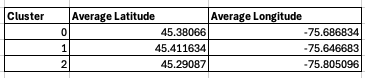
#### Cluster 2
- concentrated around 45.43 latitude and -75.69 longiture. Most likely a prime location, such as tourist areas or popular neighborhood with convenience and proximity to attractions which aligns with high-priced accomodations in this cluster,
- likely the Central Ottawa locations like Byward MArket
#### Cluster 1
- concentrated around latitude 45.41 and longitude -75.65, most likely a mixed neighborhood with blend of commercial and residantial area which explains Entire home/apt and Private room accomodations in this cluster.
#### Cluster 0
- concentrated around latitude 45.29 and longitude -75.81, this area is likely a suburban or less central location, which refers to budget-friently accomodations like Private Room dominating this cluster.
- likely the suburban areas in Ottawa like Barrhaven, farther from the city center more to the residential area



# --------------------------------------------------------------------
# -------------------PRESENTATION-------------------------------------
# --------------------------------------------------------------------

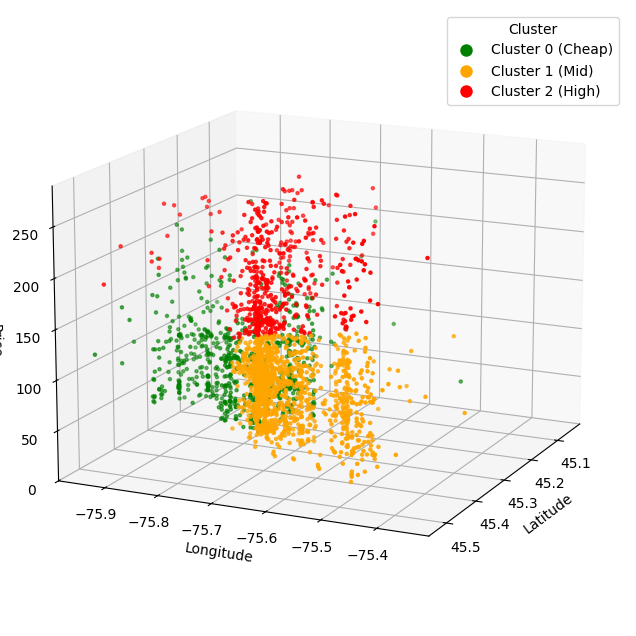

Price Statistics by Cluster (0=Cheap, 1=Mid, 2=High):
               mean  median    min    max
cluster                                  
0         82.860244    75.0   25.0  225.0
1         86.421324    90.5   18.0  171.0
2        188.354207   182.0  129.0  271.0
   latitude  longitude  price  cluster cluster_name
0  45.39084  -75.75621  159.0        2         High
1  45.16820  -75.71208  228.0        2         High
2  45.40550  -75.67612   78.0        1          Mid
3  45.26910  -75.72197   63.0        0        Cheap
4  45.40455  -75.73130  105.0        1          Mid


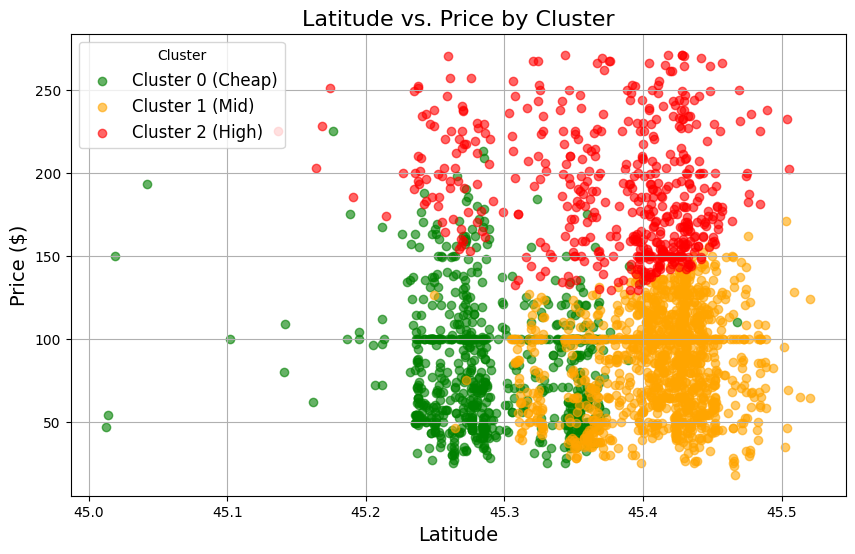

In [70]:
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D

# Ensure globals exist:
# CLUSTER_LABELS = {0: "Cheap", 1: "Mid", 2: "High"}
# COLORS = ['green', 'orange', 'red']  # 0=Cheap, 1=Mid, 2=High
N_CLUSTERS = len(CLUSTER_LABELS)

# Colormap from global COLORS
cmap = mcolors.ListedColormap(CLUSTER_COLORS)

# Load your data
data = pd.read_csv('cleaned_DATA_AIRBNB2_with_price_clusters.csv')

# Select relevant columns
X = data[['latitude', 'longitude', 'price']]

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-means clustering with a fixed random seed
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
kmeans.fit(X_scaled)
data['cluster'] = kmeans.labels_

# Relabel clusters so 0=Cheap, 1=Mid, 2=High by ordering centroids on the (standardized) price dimension ASC
centroids = kmeans.cluster_centers_
sorted_clusters = np.argsort(centroids[:, 2])  # ascending => cheapest -> priciest
label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted_clusters)}
data['cluster'] = data['cluster'].map(label_mapping)

# Human-readable cluster name from globals
data['cluster_name'] = data['cluster'].map(CLUSTER_LABELS)

# 3D Visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    data['latitude'], data['longitude'], data['price'],
    c=data['cluster'], cmap=cmap, s=5
)

# Legend built from globals
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           label=f'Cluster {i} ({CLUSTER_LABELS[i]})',
           markerfacecolor=CLUSTER_COLORS[i], markersize=10)
    for i in range(N_CLUSTERS)
]
ax.legend(handles=legend_elements, title='Cluster')

# Labels & limits
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Price')
ax.set_xlim(left=data['latitude'].min())
ax.set_ylim(bottom=data['longitude'].min())
ax.set_zlim(bottom=0)
ax.view_init(elev=15, azim=25)
plt.show()

# Price statistics by cluster
price_stats = data.groupby('cluster')['price'].agg(['mean', 'median', 'min', 'max'])
print("Price Statistics by Cluster (0=Cheap, 1=Mid, 2=High):")
print(price_stats)

# Preview rows
print(data[['latitude', 'longitude', 'price', 'cluster', 'cluster_name']].head())

# 2D Scatterplot: Latitude vs. Price (use globals for colors/labels)
plt.figure(figsize=(10, 6))
for i in range(N_CLUSTERS):
    subset = data[data['cluster'] == i]
    plt.scatter(subset['latitude'], subset['price'],
                color=CLUSTER_COLORS[i], label=f'Cluster {i} ({CLUSTER_LABELS[i]})', alpha=0.6)
plt.title('Latitude vs. Price by Cluster', fontsize=16)
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('Price ($)', fontsize=14)
plt.legend(title='Cluster', fontsize=12)
plt.grid(True)
plt.show()


In [71]:
import pandas as pd
import folium
from folium.plugins import HeatMap

# Load your data with cluster labels
data = pd.read_csv('cleaned_DATA_AIRBNB2_with_price_clusters.csv')

# Create a base map centered on Ottawa
ottawa_center = [45.4215, -75.6972]  # Downtown Ottawa coordinates
m = folium.Map(location=ottawa_center, zoom_start=12)

# Prepare data for the heatmap
# We'll use latitude, longitude, and cluster as the weight for the heatmap
heatmap_data = data[['latitude', 'longitude', 'cluster']].values.tolist()

# Create a heatmap layer
HeatMap(heatmap_data, min_opacity=0.4, max_zoom=15, radius=15, blur=10).add_to(m)

# Add a title to the map
title_html = '''
             <h3 align="center" style="font-size:16px"><b>Geospatial Heatmap of Airbnb Clusters in Ottawa</b></h3>
             '''
m.get_root().html.add_child(folium.Element(title_html))

# Save the map to an HTML file (optional)
m.save('ottawa_airbnb_cluster_heatmap2.html')

# Display the map in a Jupyter Notebook (if using one)
m

#### CLUSTER SPECIFIC HEATMAPS

In [72]:
# Heatmap for each cluster
clusters = data['cluster'].unique()
for cluster in clusters:
    cluster_data = data[data['cluster'] == cluster]
    heatmap_data_cluster = cluster_data[['latitude', 'longitude', 'cluster']].values.tolist()
    
    # Create a base map for the cluster
    m_cluster = folium.Map(location=ottawa_center, zoom_start=12)
    
    # Create a heatmap layer for the cluster
    HeatMap(heatmap_data_cluster, min_opacity=0.4, max_zoom=15, radius=15, blur=10).add_to(m_cluster)
    
    # Add a title to the map
    title_html_cluster = f'''
                 <h3 align="center" style="font-size:16px"><b>Geospatial Heatmap of Airbnb Clusters in Ottawa (Cluster {cluster})</b></h3>
                 '''
    m_cluster.get_root().html.add_child(folium.Element(title_html_cluster))
    
    # Save the map to an HTML file
    m_cluster.save(f'ottawa_airbnb_cluster_heatmap_cluster2_{cluster}.html')
    
    # Display the map in a Jupyter Notebook (if using one)
    m_cluster
    #from IPython.display import IFrame
    #IFrame(f'ottawa_airbnb_cluster_heatmap_cluster2_{cluster}.html', width='100%', height=600)

#### COLOR BY PRICE

In [73]:
import pandas as pd
import folium
from folium.plugins import HeatMap

# Assumes globals defined earlier:
# CLUSTER_LABELS = {0: "Cheap", 1: "Mid", 2: "High"}
# COLORS = ['green', 'orange', 'red']  # 0=Cheap, 1=Mid, 2=High

# Load your data with cluster labels
data = pd.read_csv('cleaned_DATA_AIRBNB2_with_price_clusters.csv')

# Create a base map centered on Ottawa
ottawa_center = [45.4215, -75.6972]  # Downtown Ottawa coordinates
m = folium.Map(location=ottawa_center, zoom_start=12)

# Add one heatmap per cluster (toggle with layer control)
for i, label in CLUSTER_LABELS.items():
    cluster_points = data.loc[data['cluster'] == i, ['latitude', 'longitude']].values.tolist()
    if cluster_points:  # avoid errors if cluster is empty
        heat_layer = HeatMap(
            cluster_points,
            name=f'Cluster {i} ({label})',
            min_opacity=0.4, max_zoom=15, radius=15, blur=10
        )
        heat_layer.add_to(folium.FeatureGroup(name=f'Cluster {i} ({label})', show=True).add_to(m))

# Add layer control so you can toggle clusters
folium.LayerControl().add_to(m)

# Add a title to the map
title_html = '''
             <h3 align="center" style="font-size:16px"><b>Geospatial Heatmap of Airbnb Clusters in Ottawa</b></h3>
             '''
m.get_root().html.add_child(folium.Element(title_html))

# Save the map to an HTML file (optional)
m.save('ottawa_airbnb_cluster_heatmap2.html')

# Display in Jupyter
m


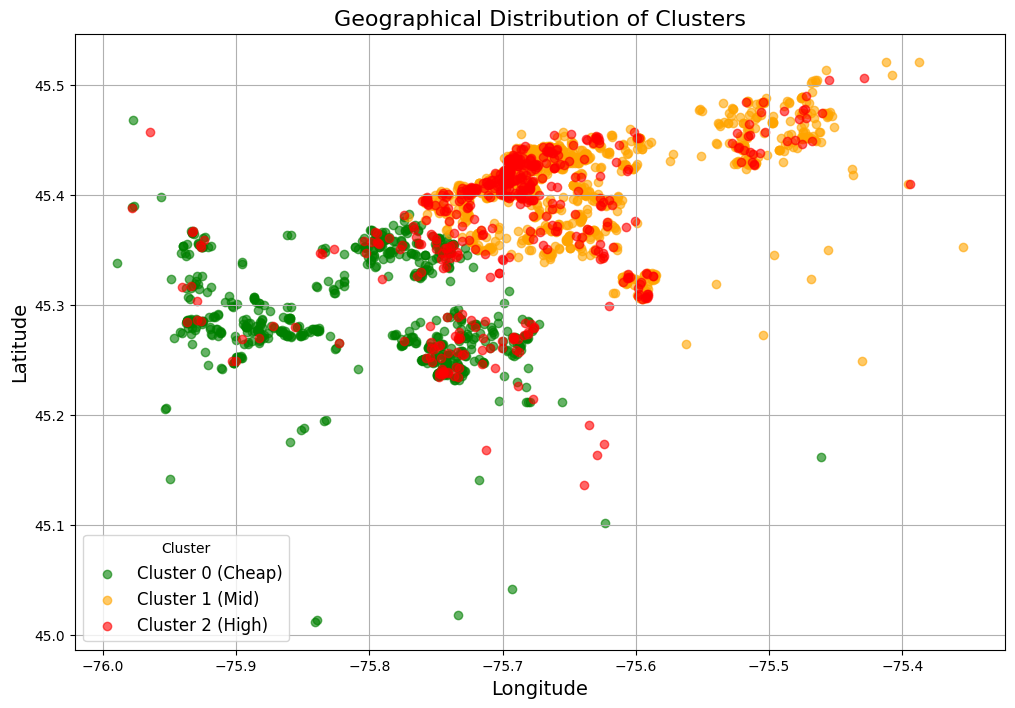

In [74]:
import pandas as pd
import matplotlib.pyplot as plt

# Assumes globals defined earlier:
# CLUSTER_LABELS = {0: "Cheap", 1: "Mid", 2: "High"}
# COLORS = ['green', 'orange', 'red']  # 0=Cheap, 1=Mid, 2=High

# Load your data
data = pd.read_csv('cleaned_DATA_AIRBNB2_with_price_clusters.csv')

# Plot geographical distribution of all clusters
plt.figure(figsize=(12, 8))

# Plot each cluster with its global color + label
for i, label in CLUSTER_LABELS.items():
    subset = data[data['cluster'] == i]
    plt.scatter(
        subset['longitude'], subset['latitude'],
        color=CLUSTER_COLORS[i], label=f'Cluster {i} ({label})', alpha=0.6
    )

# Add titles and labels
plt.title('Geographical Distribution of Clusters', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.legend(title='Cluster', fontsize=12)
plt.grid(True)

# Show the plot
plt.show()


In [75]:
import pandas as pd
import folium

# Assumes globals exist:
# CLUSTER_LABELS = {0: "Cheap", 1: "Mid", 2: "High"}
# CLUSTER_COLORS = ['green', 'orange', 'red']  # 0=Cheap, 1=Mid, 2=High

# Load your data
data = pd.read_csv('cleaned_DATA_AIRBNB2_with_price_clusters.csv')

# Base map
ottawa_center = [45.4215, -75.6972]
m = folium.Map(location=ottawa_center, zoom_start=12)

# Points
for _, row in data.iterrows():
    c = int(row['cluster'])
    color = CLUSTER_COLORS[c]
    label = CLUSTER_LABELS[c]
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color=color, fill=True, fill_color=color, fill_opacity=0.6,
        tooltip=(f"<div style='font-size: 14px; color: black;'>"
                 f"<strong>Cluster {c} ({label})</strong><br>"
                 f"Price: ${row['price']}</div>"),
        popup=f"Cluster {c} ({label}): ${row['price']}"
    ).add_to(m)

# Centroids (colored to match cluster)
centroids = data.groupby('cluster')[['latitude', 'longitude']].mean()
for c, coords in centroids.iterrows():
    c = int(c)
    color = CLUSTER_COLORS[c]
    label = CLUSTER_LABELS[c]
    folium.Marker(
        location=[coords['latitude'], coords['longitude']],
        icon=folium.Icon(color=color, icon="star", prefix="fa"),
        popup=f"Centroid of Cluster {c} ({label})"
    ).add_to(m)

# Title
title_html = """
<h3 align="center" style="font-size:16px">
<b>Geographical Distribution of Clusters with Centroids</b>
</h3>
"""
m.get_root().html.add_child(folium.Element(title_html))

# ---- Legend (matches globals) ----
legend_items = "".join(
    f"""
    <div style="display:flex; align-items:center; margin:2px 0;">
      <span style="display:inline-block; width:14px; height:14px; 
                   background:{CLUSTER_COLORS[i]}; border:1px solid #555; margin-right:6px;"></span>
      <span style="font-size:12px;">Cluster {i} ({CLUSTER_LABELS[i]})</span>
    </div>
    """
    for i in range(len(CLUSTER_LABELS))
)

legend_html = f"""
<div style="
     position: fixed; 
     bottom: 20px; left: 20px; z-index: 9999; 
     background: rgba(255,255,255,0.95); 
     padding: 10px 12px; border: 1px solid #aaa; 
     border-radius: 6px; box-shadow: 0 1px 4px rgba(0,0,0,0.2);
     ">
  <div style="font-weight:600; margin-bottom:6px; font-size:12px;">Legend</div>
  {legend_items}
  <div style="margin-top:6px; font-size:11px;">
    <span style="display:inline-block; width:14px; height:14px; 
                 border-radius:7px; background:#000; margin-right:6px;"></span>
    Centroid (star)
  </div>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# Save / display
m.save('ottawa_clusters_map_with_centroids_legend.html')
m


/var/folders/g4/9k6f6c210td2wglzkky_kdhw0000gn/T/ipykernel_70663/1810563155.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='price', data=data, palette=CLUSTER_COLORS)


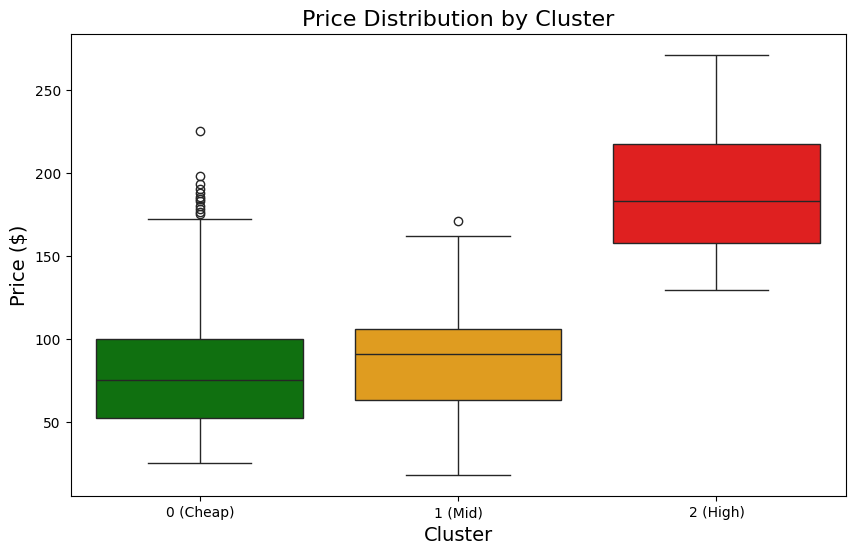

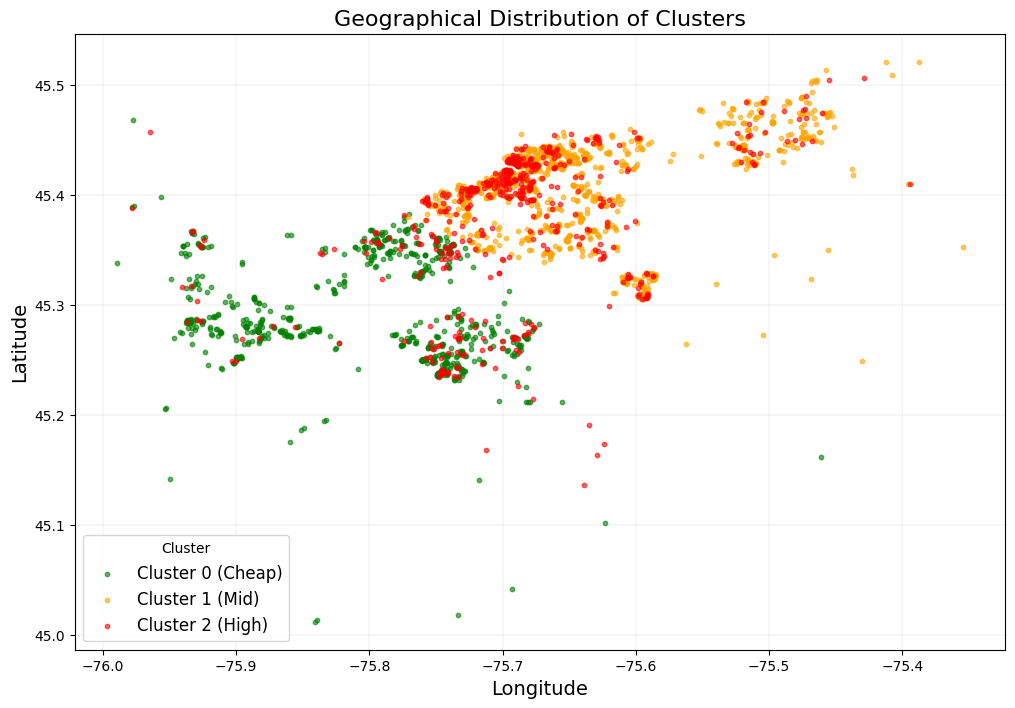

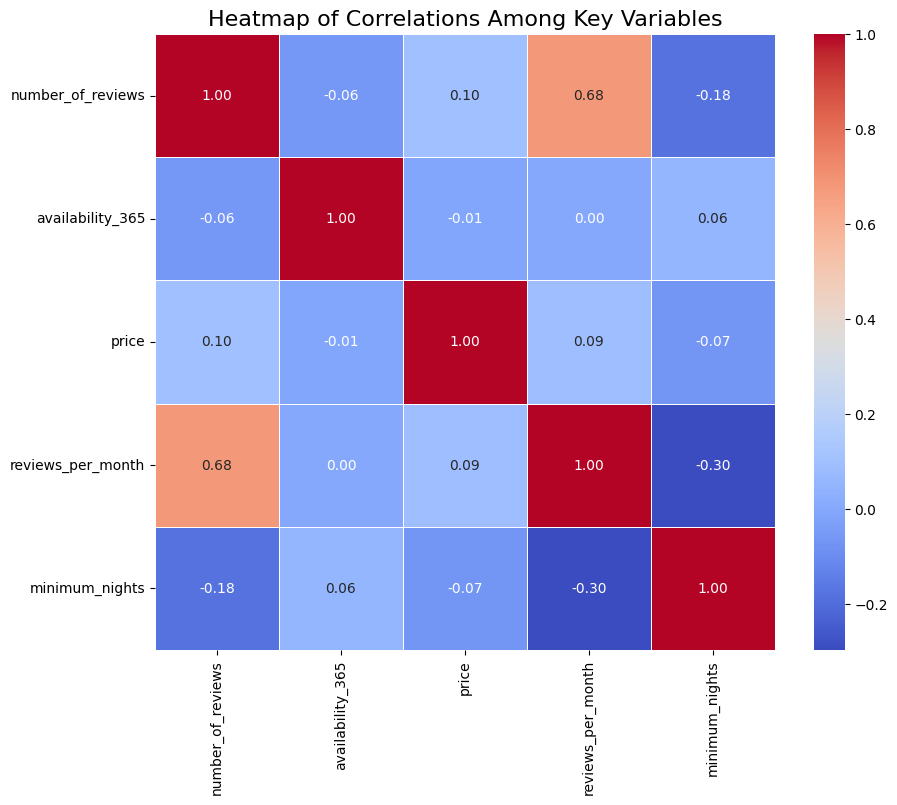

Mann-Whitney U Test (Cluster 0 vs. Cluster 1): p-value = 0.0000
Mann-Whitney U Test (Cluster 1 vs. Cluster 2): p-value = 0.0000
Mann-Whitney U Test (Cluster 0 vs. Cluster 2): p-value = 0.0000
Done. Reused existing clusters. Visualizations and outputs saved.


In [76]:
# Assumes you've set these once at the top of your notebook:
# CLUSTER_LABELS = {0: "Cheap", 1: "Mid", 2: "High"}
# COLORS = ['green', 'orange', 'red']  # 0=Cheap, 1=Mid, 2=High

# ======================
# Imports
# ======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from scipy.stats import mannwhitneyu

# ======================
# Load existing clustered data
# ======================
data = pd.read_csv('cleaned_DATA_AIRBNB2_with_price_clusters.csv')

# Basic checks & cleanup
if 'cluster' not in data.columns:
    raise ValueError("The file must contain a 'cluster' column.")
data = data.dropna(subset=['latitude', 'longitude', 'price', 'cluster']).copy()

# Ensure integer clusters and valid label range
data['cluster'] = pd.to_numeric(data['cluster'], errors='coerce').astype(int)
valid_clusters = set(CLUSTER_LABELS.keys())
data = data[data['cluster'].isin(valid_clusters)].copy()

# Optional: add human-friendly name if missing
if 'cluster_name' not in data.columns:
    data['cluster_name'] = data['cluster'].map(CLUSTER_LABELS)

N_CLUSTERS = len(CLUSTER_LABELS)

# ======================
# 1) Boxplot: Price Distribution by Cluster
# ======================
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='price', data=data, palette=CLUSTER_COLORS)
plt.title('Price Distribution by Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Price ($)', fontsize=14)
plt.xticks(
    ticks=range(N_CLUSTERS),
    labels=[f"{i} ({CLUSTER_LABELS[i]})" for i in range(N_CLUSTERS)]
)
plt.savefig('price_distribution_by_cluster2.png', bbox_inches='tight')
plt.show()

# ======================
# 2) Geographical Distribution (Scatter)
# ======================
plt.figure(figsize=(12, 8))
for i in range(N_CLUSTERS):
    subset = data[data['cluster'] == i]
    plt.scatter(
        subset['longitude'], subset['latitude'],
        color=CLUSTER_COLORS[i], label=f'Cluster {i} ({CLUSTER_LABELS[i]})', alpha=0.6, s=10
    )
plt.title('Geographical Distribution of Clusters', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.legend(title='Cluster', fontsize=12)
plt.grid(True, linewidth=0.3, alpha=0.5)
plt.savefig('geographical_distribution_scatterplot2.png', bbox_inches='tight')
plt.show()

# ======================
# 3) Folium Map (Markers by Cluster)
# ======================
ottawa_center = [45.4215, -75.6972]  # Downtown Ottawa
m = folium.Map(location=ottawa_center, zoom_start=12)

for i in range(N_CLUSTERS):
    subset = data[data['cluster'] == i]
    color = CLUSTER_COLORS[i]
    label = CLUSTER_LABELS[i]
    for _, row in subset.iterrows():
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=3,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.6,
            tooltip=(f"<div style='font-size: 14px; color: black;'>"
                     f"<strong>Cluster {i} ({label})</strong><br>"
                     f"Price: ${row['price']}</div>"),
            popup=f"Cluster {i} ({label}): ${row['price']}"
        ).add_to(m)

title_html = """
<h3 align="center" style="font-size:16px">
<b>Geographical Distribution of Clusters</b>
</h3>
"""
m.get_root().html.add_child(folium.Element(title_html))
m.save('ottawa_clusters_map2.html')
m  # In Jupyter, this will display the map

# ======================
# 4) Correlation Heatmap (unchanged)
# ======================
corr_cols = [c for c in ['number_of_reviews', 'availability_365', 'price',
                         'reviews_per_month', 'minimum_nights'] if c in data.columns]
if corr_cols:
    corr_matrix = data[corr_cols].corr(numeric_only=True)
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Heatmap of Correlations Among Key Variables', fontsize=16)
    plt.savefig('correlation_heatmap2.png', bbox_inches='tight')
    plt.show()
else:
    print("Correlation heatmap skipped: none of the expected columns were found.")

# ======================
# 5) Mann-Whitney U Tests (Price differences between clusters)
# ======================
cluster_prices = {i: data.loc[data['cluster'] == i, 'price'].dropna() for i in range(N_CLUSTERS)}
def mw(a, b):
    return mannwhitneyu(cluster_prices[a], cluster_prices[b], alternative='two-sided')[1]

if all(i in cluster_prices and len(cluster_prices[i]) > 0 for i in range(N_CLUSTERS)):
    print(f"Mann-Whitney U Test (Cluster 0 vs. Cluster 1): p-value = {mw(0,1):.4f}")
    print(f"Mann-Whitney U Test (Cluster 1 vs. Cluster 2): p-value = {mw(1,2):.4f}")
    print(f"Mann-Whitney U Test (Cluster 0 vs. Cluster 2): p-value = {mw(0,2):.4f}")
else:
    print("Mann-Whitney tests skipped: one or more clusters have no price data.")

# ======================
# 6) Save script output summary
# ======================
with open('script_output2.txt', 'w') as f:
    f.write("Price Statistics by Cluster:\n")
    f.write(
        data.groupby('cluster')['price'].agg(['mean', 'median', 'min', 'max']).to_string()
    )
    f.write("\n\nRoom Type Distribution by Cluster:\n")
    if 'room_type' in data.columns:
        f.write(
            data.groupby(['cluster', 'room_type']).size().unstack(fill_value=0).to_string()
        )
    else:
        f.write("(column 'room_type' not found)\n")
    f.write("\n\nGeographical Distribution by Cluster (mean lat/long):\n")
    f.write(
        data.groupby('cluster')[['latitude', 'longitude']].mean().to_string()
    )
    if all(i in cluster_prices and len(cluster_prices[i]) > 0 for i in range(N_CLUSTERS)):
        f.write("\n\nMann-Whitney U Test Results:\n")
        f.write(f"Cluster 0 vs. Cluster 1: p-value = {mw(0,1):.4f}\n")
        f.write(f"Cluster 1 vs. Cluster 2: p-value = {mw(1,2):.4f}\n")
        f.write(f"Cluster 0 vs. Cluster 2: p-value = {mw(0,2):.4f}\n")
    else:
        f.write("\n\nMann-Whitney tests skipped due to insufficient cluster data.\n")

print("Done. Reused existing clusters. Visualizations and outputs saved.")
